# Methylation Metaplot

scaled position of genes and features - stetch/shrink individual genes/features to all be the same length, and see if there's a similar distribution of methylation for each treatment combination


**Theoretical pipeline:** (loosely following [Venkataraman et al., 2020](https://github.com/epigeneticstoocean/paper-gonad-meth/blob/master/code/13-DML-Characterization.Rmd))
- scale each gene feature from 0% to 100%
	- calculate gene length (gene.end - gene.start = length)
	- calculate absolute position of CpG (feature.start - gene.start = abs.position)
		- only methylated CpGs? so those with at least 5 sequences? 
		- first plot all 5 replicates (in same color), then can collapse? (so CpG methylated if at least 3/5 replicates have 5 seqs or more)
	- calculate scaled position of CpG in feature/gene (abs.position / geneLength)
- plot histogram/line plot

# 0. load libraries and bed/csv files

In [2]:
library(tidyverse)
library(IRanges)
library(GenomicRanges)

**genomic feature file**

In [3]:
allGenes <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/genomic_feature_tracks/CV_gene_sorted.bed', sep='\t', header=FALSE)
colnames(allGenes) <- c('chromosome', 'start', 'end')
head(allGenes)

,chromosome,start,end
,<chr>,<int>,<int>
1,NC_035780.1,13578,14594
2,NC_035780.1,28961,33324
3,NC_035780.1,43111,66897
4,NC_035780.1,85606,95254
5,NC_035780.1,99840,106460
6,NC_035780.1,108305,110077


**CpG counts**

already generated this from CpG_coverage script

In [4]:
cpg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_methyl_assembly/assembly_pipeline_files/genomic_bed_files/CpG_multicov/all_CpGmulticov.csv')
head(cpg)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC1,HC2,HC3,HC4,HC5,HH1,HH2,HH3,HH4,HH5
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,NC_035780.1,54,56,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,NC_035780.1,75,77,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,NC_035780.1,93,95,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,NC_035780.1,103,105,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,NC_035780.1,116,118,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,NC_035780.1,134,136,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


# 1. Scale the feature
Essentially stretching the feature of interest (gene, exon, intron, UTR) to all be the same length, then plotting the absolute position of methylated CpGs along the feature to look at distribution patterns

### 1a. calculate feature length
(although I end up doing this later in the bigger df)

In [5]:
allGenes$length <- allGenes$end - allGenes$start
colnames(allGenes) <- c('chromosome', 'start', 'stop', 'length')
head(allGenes)

,chromosome,start,stop,length
,<chr>,<int>,<int>,<int>
1,NC_035780.1,13578,14594,1016
2,NC_035780.1,28961,33324,4363
3,NC_035780.1,43111,66897,23786
4,NC_035780.1,85606,95254,9648
5,NC_035780.1,99840,106460,6620
6,NC_035780.1,108305,110077,1772


### 1b. calculate absolute position of CpG 
CpG start - feature start = absolute position

In [6]:
subset_CpGs <- function(df1, df2) {
    # find the genomic range of the first df (the CpGs)
    df1_gr <- GRanges(seqnames = df1$chromosome, 
                  ranges = IRanges(start = df1$start, end = df1$stop))
    
    # find the genomic range of the second df (genomic feature)
    df2_gr <- GRanges(seqnames = df2$chromosome, 
                  ranges = IRanges(start = df2$start, end = df2$stop))

    # find overlaps
    overlaps <- findOverlaps(df1_gr, df2_gr, type = "within")

    # get the subset of cpgs within the genomic feature
    cpg_overlap <- df1[queryHits(overlaps), ]
    
    # get the gene start and stop for each overlapping CpG
    gene_start <- df2$start[subjectHits(overlaps)]
    gene_stop <- df2$stop[subjectHits(overlaps)]
    
    # add the gene start and stop to the cpg_overlap dataframe
    cpg_overlap$gene_start <- gene_start
    cpg_overlap$gene_stop <- gene_stop
    
    return(cpg_overlap)
}

In [7]:
geneCpG <- subset_CpGs(cpg, allGenes)
head(geneCpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC3,HC4,HC5,HH1,HH2,HH3,HH4,HH5,gene_start,gene_stop
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,13578,14594
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,13578,14594
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,13578,14594
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,13578,14594
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,13578,14594
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,13578,14594


In [8]:
# find the absolute position of the CpG within the feature
geneCpG$cpg_abs.pos <- geneCpG$start - geneCpG$gene_start
head(geneCpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC4,HC5,HH1,HH2,HH3,HH4,HH5,gene_start,gene_stop,cpg_abs.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,13578,14594,19
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,13578,14594,73
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,13578,14594,147
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,13578,14594,566
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,13578,14594,852
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,13578,14594,875


### 1c. calculate scaled position of CpG 
CpG abs.position / geneLength

In [9]:
# add gene length to df
geneCpG$geneLength <- geneCpG$gene_stop - geneCpG$gene_start
head(geneCpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HC5,HH1,HH2,HH3,HH4,HH5,gene_start,gene_stop,cpg_abs.pos,geneLength
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,13578,14594,19,1016
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,13578,14594,73,1016
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,13578,14594,147,1016
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,13578,14594,566,1016
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,13578,14594,852,1016
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,0,13578,14594,875,1016


In [10]:
# scaled position
geneCpG$cpg_scaled.pos <- geneCpG$cpg_abs.pos / geneCpG$geneLength
head(geneCpG)

,chromosome,start,stop,CG_motif,CC1,CC2,CC3,CC4,CC5,CH1,⋯,HH1,HH2,HH3,HH4,HH5,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
351,NC_035780.1,13597,13599,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,13578,14594,19,1016,0.01870079
352,NC_035780.1,13651,13653,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,13578,14594,73,1016,0.07185039
353,NC_035780.1,13725,13727,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,13578,14594,147,1016,0.14468504
354,NC_035780.1,14144,14146,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,13578,14594,566,1016,0.55708661
355,NC_035780.1,14430,14432,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,13578,14594,852,1016,0.83858268
356,NC_035780.1,14453,14455,CG_motif,0,0,0,0,0,0,⋯,0,0,0,0,0,13578,14594,875,1016,0.86122047


### 2. plot

but first need to separate out the treatments??

In [11]:
CC_df <- geneCpG %>% 
  select(chromosome, start, stop, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("CC"))

HH_df <- geneCpG %>% 
  select(chromosome, start, stop, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("HH"))

CH_df <- geneCpG %>% 
  select(chromosome, start, stop, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("CH"))

HC_df <- geneCpG %>% 
  select(chromosome, start, stop, gene_start, gene_stop, cpg_abs.pos, geneLength, cpg_abs.pos, cpg_scaled.pos, starts_with("HC"))

In [12]:
head(HH_df)
dim(HH_df)

,chromosome,start,stop,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos,HH1,HH2,HH3,HH4,HH5
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
351,NC_035780.1,13597,13599,13578,14594,19,1016,0.01870079,0,0,0,0,0
352,NC_035780.1,13651,13653,13578,14594,73,1016,0.07185039,0,0,0,0,0
353,NC_035780.1,13725,13727,13578,14594,147,1016,0.14468504,0,0,0,0,0
354,NC_035780.1,14144,14146,13578,14594,566,1016,0.55708661,0,0,0,0,0
355,NC_035780.1,14430,14432,13578,14594,852,1016,0.83858268,0,0,0,0,0
356,NC_035780.1,14453,14455,13578,14594,875,1016,0.86122047,0,0,0,0,0


[1] 8189462      13

In [15]:
hh_meta <- HH_df %>%
  select(cpg_scaled.pos, HH1, HH2, HH3, HH4, HH5) %>%
  pivot_longer(cols = c(HH1, HH2, HH3, HH4, HH5), names_to = "sample", values_to = "methylation_level") %>%
  group_by(cpg_scaled.pos) %>%
  summarise(avg_methylation = mean(methylation_level)) %>%
mutate(treatment <- 'HH') %>%
mutate(phase1 <- 'Hypoxia') %>%
mutate(phase2 <- 'Hypoxia')

head(hh_meta)

cpg_scaled.pos,avg_methylation,"treatment <- ""HH""","phase1 <- ""Hypoxia""","phase2 <- ""Hypoxia"""
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0.09305211,HH,Hypoxia,Hypoxia
2.565866e-06,0.00000000,HH,Hypoxia,Hypoxia
2.692471e-06,0.00000000,HH,Hypoxia,Hypoxia
4.193250e-06,0.00000000,HH,Hypoxia,Hypoxia
4.452677e-06,0.00000000,HH,Hypoxia,Hypoxia
5.126654e-06,0.00000000,HH,Hypoxia,Hypoxia


proof of concept:

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


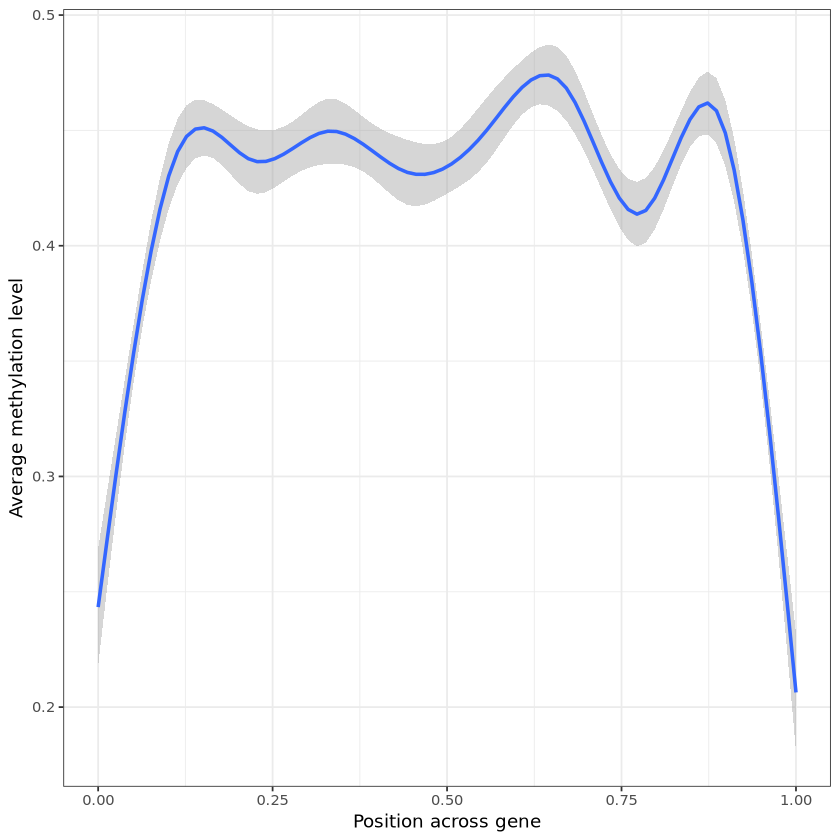

In [36]:
# Make the metaplot
ggplot(metaplot_df, aes(x = cpg_scaled.pos, y = avg_methylation)) +
  geom_smooth() +
  labs(x = "Position across gene", y = "Average methylation level") +
  theme_bw()

this is just HH - want to do this for the other treatment combos and have all on one plot - trying to create a function that does this to be more efficient

also - probably want 1kb upstream and downstream of the gene too to show high intragenic methylation

In [13]:
create_meta_df <- function(df, treatment) {
  # Determine phase 1 and phase 2 based on treatment
  phase1 <- ifelse(grepl("C", treatment), "Control", "Hypoxia")
  phase2 <- ifelse(grepl("H$", treatment), "Hypoxia", "Control")
  
  # Create meta dataframe
  cols_to_select <- c("cpg_scaled.pos", grep(paste0("^", treatment), colnames(df), value = TRUE))
  
  meta_df <- df %>%
    select(all_of(cols_to_select)) %>%
    pivot_longer(cols = -cpg_scaled.pos, names_to = "sample", values_to = "methylation_level") %>%
    group_by(cpg_scaled.pos) %>%
    summarise(avg_methylation = mean(methylation_level)) %>%
    mutate(treatment = treatment,
           phase1 = phase1,
           phase2 = phase2)
  
  return(meta_df)
}

In [17]:
ch_meta <- create_meta_df(CH_df, 'CH')
head(ch_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0.1166253,CH,Control,Hypoxia
2.565866e-06,0.0000000,CH,Control,Hypoxia
2.692471e-06,0.0000000,CH,Control,Hypoxia
4.193250e-06,0.0000000,CH,Control,Hypoxia
4.452677e-06,0.0000000,CH,Control,Hypoxia
5.126654e-06,0.0000000,CH,Control,Hypoxia


In [18]:
cc_meta <- create_meta_df(CC_df, 'CC')
head(cc_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0.07543424,CC,Control,Control
2.565866e-06,0.00000000,CC,Control,Control
2.692471e-06,0.00000000,CC,Control,Control
4.193250e-06,0.00000000,CC,Control,Control
4.452677e-06,0.00000000,CC,Control,Control
5.126654e-06,0.00000000,CC,Control,Control


In [19]:
hc_meta <- create_meta_df(HC_df, 'HC')
head(hc_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0.255335,HC,Control,Control
2.565866e-06,0.000000,HC,Control,Control
2.692471e-06,0.000000,HC,Control,Control
4.193250e-06,0.000000,HC,Control,Control
4.452677e-06,0.000000,HC,Control,Control
5.126654e-06,0.000000,HC,Control,Control


In [20]:
hh_meta <- create_meta_df(HH_df, 'HH')
head(hh_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0.09305211,HH,Hypoxia,Hypoxia
2.565866e-06,0.00000000,HH,Hypoxia,Hypoxia
2.692471e-06,0.00000000,HH,Hypoxia,Hypoxia
4.193250e-06,0.00000000,HH,Hypoxia,Hypoxia
4.452677e-06,0.00000000,HH,Hypoxia,Hypoxia
5.126654e-06,0.00000000,HH,Hypoxia,Hypoxia


In [21]:
mega_df <- rbind(hh_meta, cc_meta, hc_meta, ch_meta)
dim(mega_df)
head(mega_df)

[1] 30405460        5

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0.09305211,HH,Hypoxia,Hypoxia
2.565866e-06,0.00000000,HH,Hypoxia,Hypoxia
2.692471e-06,0.00000000,HH,Hypoxia,Hypoxia
4.193250e-06,0.00000000,HH,Hypoxia,Hypoxia
4.452677e-06,0.00000000,HH,Hypoxia,Hypoxia
5.126654e-06,0.00000000,HH,Hypoxia,Hypoxia


In [22]:
write.csv(mega_df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/metaplot_cpgGene.csv', row.names=FALSE)

In [39]:
mega_df <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/genomic_feature_tracks/twl_sideQuest/metaplot_cpgGene.csv')
head(mega_df)

,cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,0.000000e+00,0.09305211,HH,Hypoxia,Hypoxia
2,2.565866e-06,0.00000000,HH,Hypoxia,Hypoxia
3,2.692471e-06,0.00000000,HH,Hypoxia,Hypoxia
4,4.193250e-06,0.00000000,HH,Hypoxia,Hypoxia
5,4.452677e-06,0.00000000,HH,Hypoxia,Hypoxia
6,5.126654e-06,0.00000000,HH,Hypoxia,Hypoxia


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


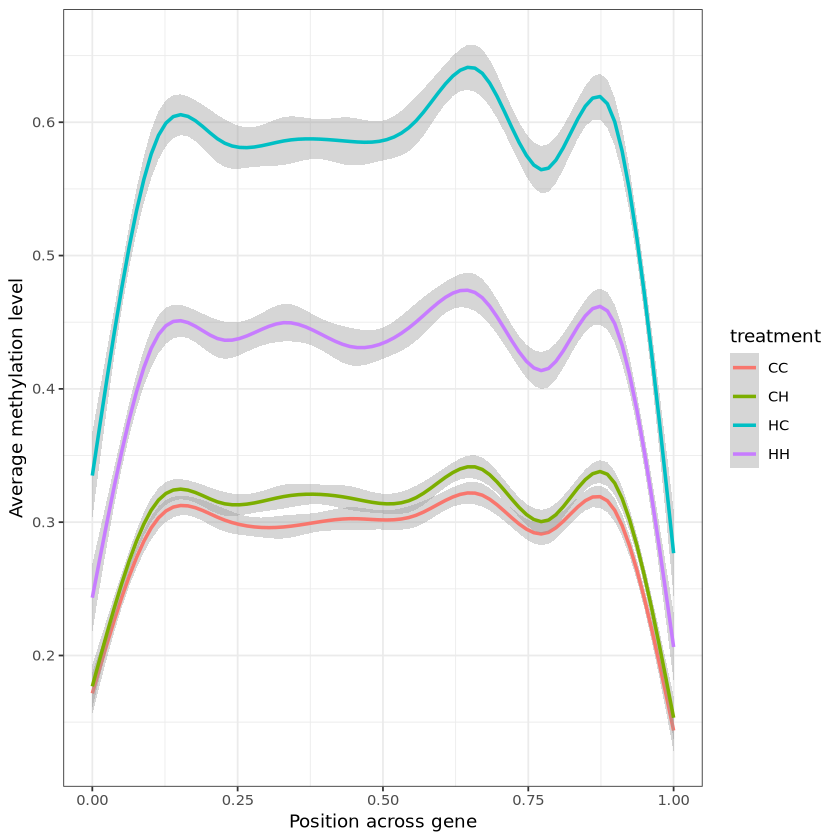

In [4]:
# Make the metaplot
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth() +
  labs(x = "Position across gene", y = "Average methylation level") +
  theme_bw()

want to show more noise...

In [ ]:
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth(se = FALSE, method = "loess", span = 0.5) +
  labs(x = "Position across gene", y = "Average methylation level",
      title = 'CpGs in all Genes') +
  theme_bw()

`geom_smooth()` using formula = 'y ~ x'


### metaplot - *only* DMGs

In [14]:
# read in DMG bed file
dmg.bed <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/genomic_feature_tracks/proportion_overlap/dmg_gff.bed', sep = '\t', header = FALSE)
colnames(dmg.bed) <- c('chromosome', 'start',  'stop')
head(dmg.bed)

,chromosome,start,stop
,<chr>,<int>,<int>
1,NC_035780.1,315522,340261
2,NC_035780.1,444907,453310
3,NC_035780.1,9011563,9043404
4,NC_035780.1,9288063,9301976
5,NC_035780.1,13324137,13332152
6,NC_035780.1,13591534,13596982


In [15]:
dim(dmg.bed)

[1] 217   3

In [16]:
head(HH_df)
dim(HH_df)

,chromosome,start,stop,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos,HH1,HH2,HH3,HH4,HH5
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
351,NC_035780.1,13597,13599,13578,14594,19,1016,0.01870079,0,0,0,0,0
352,NC_035780.1,13651,13653,13578,14594,73,1016,0.07185039,0,0,0,0,0
353,NC_035780.1,13725,13727,13578,14594,147,1016,0.14468504,0,0,0,0,0
354,NC_035780.1,14144,14146,13578,14594,566,1016,0.55708661,0,0,0,0,0
355,NC_035780.1,14430,14432,13578,14594,852,1016,0.83858268,0,0,0,0,0
356,NC_035780.1,14453,14455,13578,14594,875,1016,0.86122047,0,0,0,0,0


[1] 8189462      13

In [17]:
subset_DMGs <- function(df1, df2) {
    # find the genomic range of the first df (the CpGs)
    df1_gr <- GRanges(seqnames = df1$chromosome, 
                  ranges = IRanges(start = df1$start, end = df1$stop))
    
    # find the genomic range of the second df (genomic feature)
    df2_gr <- GRanges(seqnames = df2$chromosome, 
                  ranges = IRanges(start = df2$start, end = df2$stop))

    # find overlaps
    overlaps <- findOverlaps(df1_gr, df2_gr, type = "within")

    # get the subset of cpgs within the genomic feature
    cpg_overlap <- df1[queryHits(overlaps), ]
    
    return(cpg_overlap)
    }

In [18]:
hh.dmg <- subset_DMGs(HH_df, dmg.bed)
cc.dmg <- subset_DMGs(CC_df, dmg.bed)
ch.dmg <- subset_DMGs(CH_df, dmg.bed)
hc.dmg <- subset_DMGs(HC_df, dmg.bed)

In [19]:
head(hh.dmg)

,chromosome,start,stop,gene_start,gene_stop,cpg_abs.pos,geneLength,cpg_scaled.pos,HH1,HH2,HH3,HH4,HH5
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
7049,NC_035780.1,315523,315525,315522,340261,1,24739,4.042201e-05,0,0,0,0,0
7050,NC_035780.1,315549,315551,315522,340261,27,24739,1.091394e-03,0,0,0,0,0
7051,NC_035780.1,315563,315565,315522,340261,41,24739,1.657302e-03,0,0,0,0,0
7052,NC_035780.1,315567,315569,315522,340261,45,24739,1.818990e-03,0,0,0,0,0
7053,NC_035780.1,315618,315620,315522,340261,96,24739,3.880513e-03,0,0,0,0,0
7054,NC_035780.1,315688,315690,315522,340261,166,24739,6.710053e-03,0,0,0,0,0


In [20]:
ch_meta <- create_meta_df(ch.dmg, 'CH')
head(ch_meta)

cc_meta <- create_meta_df(cc.dmg, 'CC')
head(cc_meta)

hc_meta <- create_meta_df(hc.dmg, 'HC')
head(hc_meta)

hh_meta <- create_meta_df(hh.dmg, 'HH')
head(hh_meta)

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,CH,Control,Hypoxia
2.283418e-05,0,CH,Control,Hypoxia
3.695218e-05,0,CH,Control,Hypoxia
4.042201e-05,0,CH,Control,Hypoxia
4.436754e-05,0,CH,Control,Hypoxia
5.592137e-05,0,CH,Control,Hypoxia


cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,CC,Control,Control
2.283418e-05,0,CC,Control,Control
3.695218e-05,0,CC,Control,Control
4.042201e-05,0,CC,Control,Control
4.436754e-05,0,CC,Control,Control
5.592137e-05,0,CC,Control,Control


cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,HC,Control,Control
2.283418e-05,0,HC,Control,Control
3.695218e-05,0,HC,Control,Control
4.042201e-05,0,HC,Control,Control
4.436754e-05,0,HC,Control,Control
5.592137e-05,0,HC,Control,Control


cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,HH,Hypoxia,Hypoxia
2.283418e-05,0,HH,Hypoxia,Hypoxia
3.695218e-05,0,HH,Hypoxia,Hypoxia
4.042201e-05,0,HH,Hypoxia,Hypoxia
4.436754e-05,0,HH,Hypoxia,Hypoxia
5.592137e-05,0,HH,Hypoxia,Hypoxia


In [21]:
mega_df <- rbind(hh_meta, cc_meta, hc_meta, ch_meta)
dim(mega_df)
head(mega_df)

[1] 220624      5

cpg_scaled.pos,avg_methylation,treatment,phase1,phase2
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.000000e+00,0,HH,Hypoxia,Hypoxia
2.283418e-05,0,HH,Hypoxia,Hypoxia
3.695218e-05,0,HH,Hypoxia,Hypoxia
4.042201e-05,0,HH,Hypoxia,Hypoxia
4.436754e-05,0,HH,Hypoxia,Hypoxia
5.592137e-05,0,HH,Hypoxia,Hypoxia


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


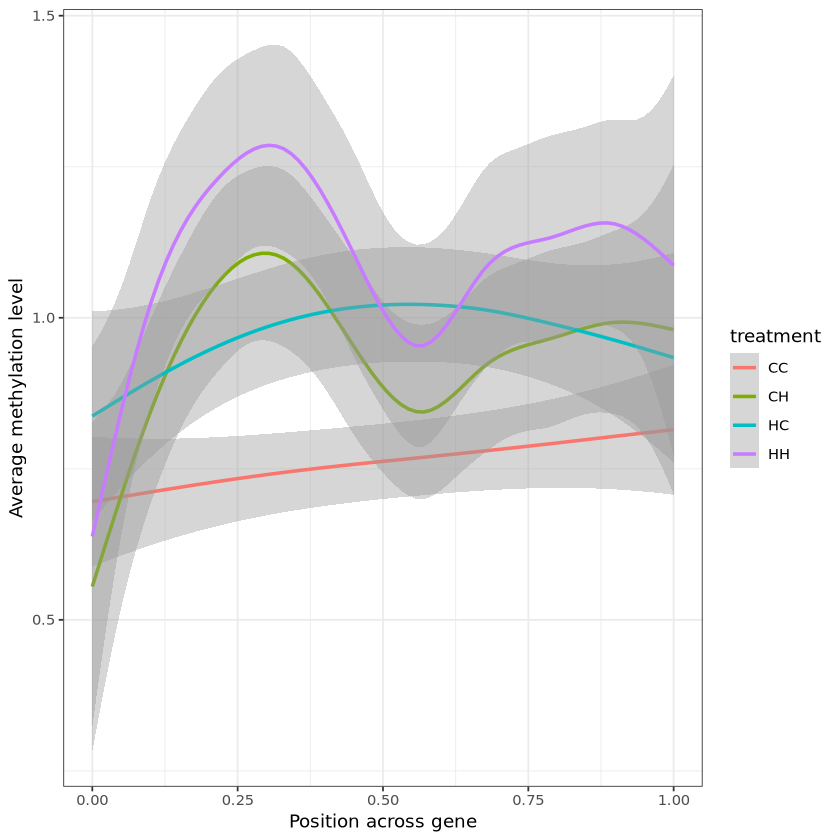

In [32]:
# Make the metaplot
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth() +
  labs(x = "Position across gene", y = "Average methylation level") +
  theme_bw()

`geom_smooth()` using formula = 'y ~ x'


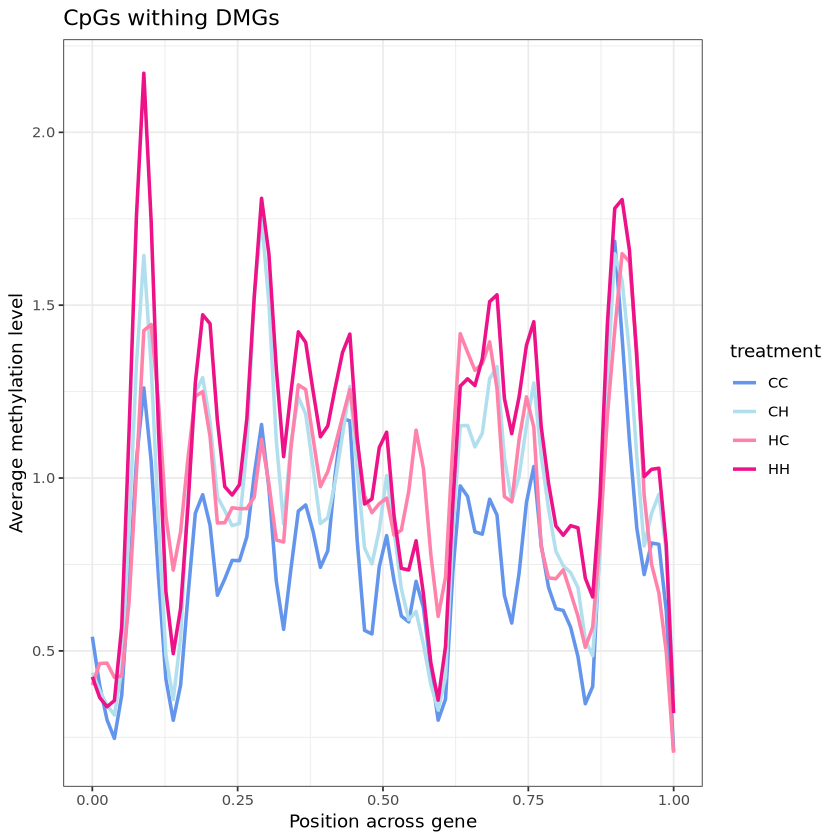

In [22]:
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth(se = FALSE, method = "loess", span = 0.1) +
  labs(x = "Position across gene", y = "Average methylation level",
      title = 'CpGs withing DMGs') +
  scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  theme_bw()

`geom_smooth()` using formula = 'y ~ x'


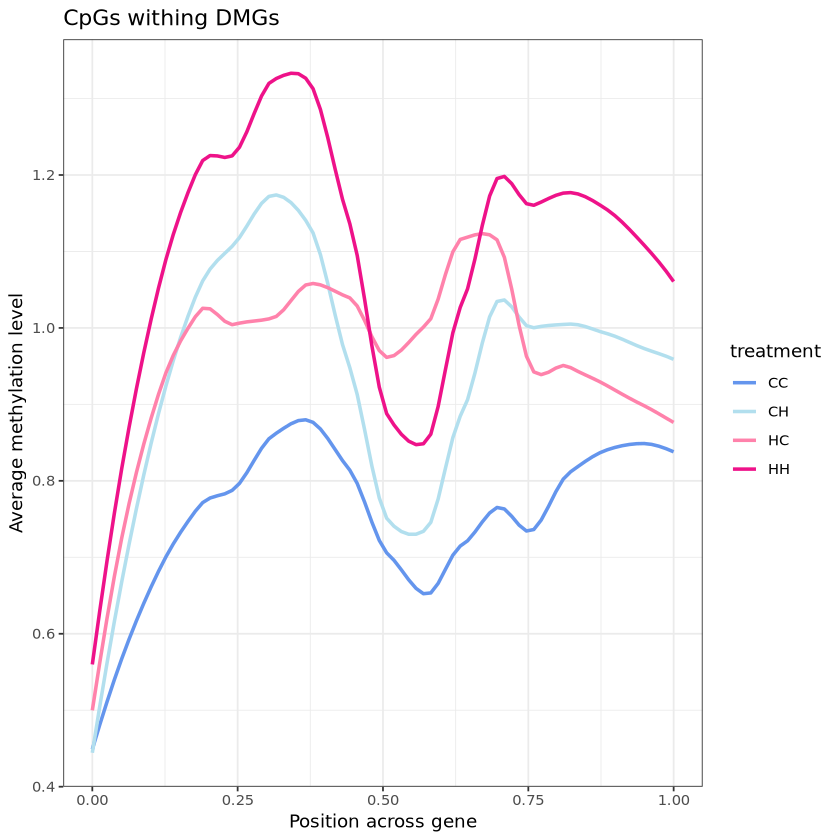

In [23]:
ggplot(mega_df, aes(x = cpg_scaled.pos, y = avg_methylation, col = treatment)) +
  geom_smooth(se = FALSE, method = "loess", span = 0.5) +
  labs(x = "Position across gene", y = "Average methylation level",
      title = 'CpGs withing DMGs') +
scale_color_manual(values = c("CC" = "cornflowerblue", 
                                "CH" = "lightblue2", 
                                "HC" = "palevioletred1", 
                                "HH" = "deeppink2")) +
  theme_bw()